In [1]:
import json
import numpy as np
import pandas as pd
import time
import math
import numpy

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

from scipy import spatial

# Devils DFTD Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

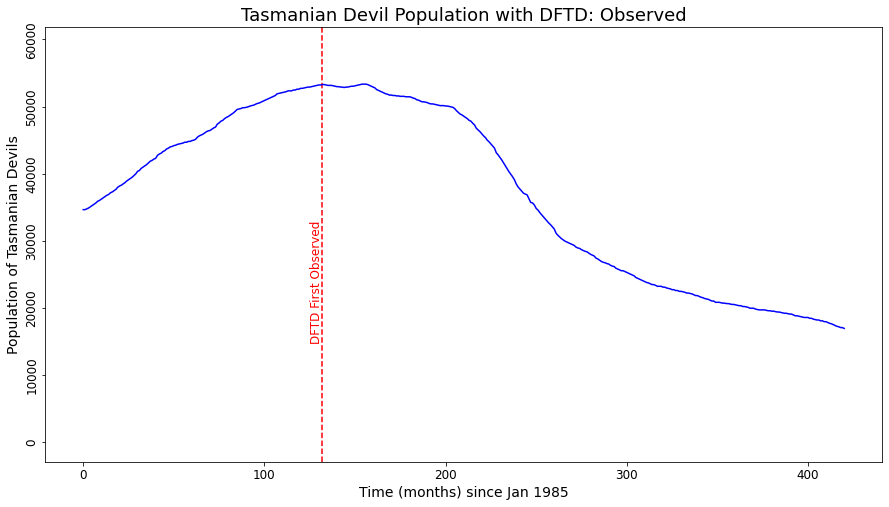

In [3]:
plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population with DFTD: Observed", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.16], '--r')
plt.ylim([-3000, max(devil_pop)*1.16])
plt.text(125, 15000, "DFTD First Observed", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
_ = plt.plot(range(len(devil_pop)), devil_pop, 'b', label='Observed Total')

## Model

In [4]:
variables = {
    "juvenile_concentration": 0.467,
    "infected_concentration": 5e-5,
    "birth_rate": 0.055,
    "maturity_rate": 0.04267,
    "infection_rate_infected": 1.675e-05,
    "infection_rate_diseased": 4e-05,
    "incubation": 19,
    "progression": 12,
    "death_rate_juvenile": 0.006,
    "death_rate_susceptible": 0.02335,
    "death_rate_over_population": 2.3e-7,
    "death_rate_infected": 0.02,
    "death_rate_diseased": 0.024,
    "DFTD_start": 95
}
variables_orig = variables.copy()

In [5]:
class DevilsPreVaccination(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="discrete",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="discrete",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        self.add_reaction([Birth, Mature])
        
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        self.add_reaction([Death_Juvenile, Death_Susceptible, Death_Exposed, Death_Infected, Death_Diseased,
                           Death_Juvenile2, Death_Susceptible2, Death_Exposed2, Death_Infected2, Death_Diseased2])
        
        
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased':1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        self.add_reaction([TransmissionI, TransmissionD, DFTD_Stage1, DFTD_Stage2])

        # Events
        if events is not None:
            self.add_event(events)

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        
    def run(self, with_pr=False, **kwargs):
        if not with_pr:
            return super().run(**kwargs)
        
        self.resolve_parameters()
        t = int(self.listOfParameters['DFTD_start'].value)
        res1 = super().run(**kwargs, t=t)
        
        if not "variables" in kwargs.keys():
            kwargs['variables'] = {}
        kwargs['variables']['Infected'] = "1"
        kwargs['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
        
        res2 = super().run(resume=res1, **kwargs)
        for species in self.listOfSpecies.keys():
            res2[0][species] = res2[0][species][:-1]
        
        return res2

## Carrying Capacity Mechanics

In [6]:
carry_cap = int(max(devil_pop)*1.16)

model = DevilsPreVaccination()
tic=time.time()
result = model.run(solver=SSACSolver, number_of_trajectories=100)
print(f"simulation complete in {time.time()-tic}s")


simulation complete in 31.04960560798645s


<ipython-input-7-8257f641ec8c>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
<ipython-input-7-8257f641ec8c>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Number of Devils 60717.0 at simulation end, 98.1% of target carrying capacity


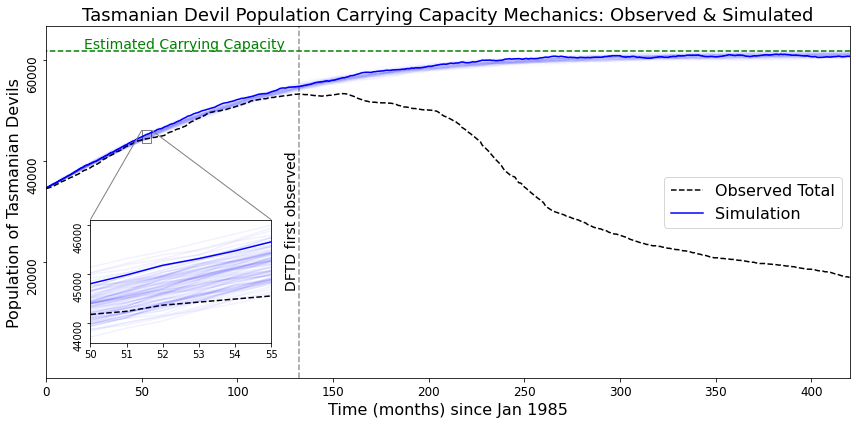

In [7]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
fig, ax1 = plt.subplots(figsize=[12, 6])

plt.title("Tasmanian Devil Population Carrying Capacity Mechanics: Observed & Simulated", fontsize=18)
ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
ax1.plot([132, 132], [-3000, max(devil_pop)*1.25], '--k', alpha=0.4)
ax1.plot([-15, result[0]['time'][-1] + 15], [carry_cap, carry_cap], '--g')
ax1.text(20, carry_cap + 500, "Estimated Carrying Capacity", color="green", fontsize=14)
ax1.text(125, 15000, "DFTD first observed", rotation="vertical", color="black", fontsize=14)
#ax1.set_xticks(fontsize=12)
#ax1.set_yticks(fontsize=12, rotation="vertical", va="center")

ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed Total')
ax1.plot(result[0]['Devils'],'b', label="Simulation")

ax1.set_xlim([0, result[0]['time'][-1]])
ax1.set_ylim([-3000, max(devil_pop)*1.25])
ax1.tick_params(axis='x', labelsize=12)
ax1.set_yticks([20000,40000,60000])
ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
ax1.legend(loc='center right', fontsize=16)

for n,r in enumerate(result):
    if n==0: continue
    ax1.plot(result[n]['Devils'],'b', alpha=0.01)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.055,0.1,0.225,0.35])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=2, loc2=1, fc="none", ec='0.5')

# plot in the inset
inst=50
ined=56
ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
ax2.plot(result[0]['time'][inst:ined], result[0]['Devils'][inst:ined],'b', label="Simulation")
ax2.set_xlim(inst,ined-1)
ax2.set_yticks([44000,45000,46000])
ax2.tick_params(axis='y', labelrotation=90)

for n,r in enumerate(result):
    if n==0: continue
    ax2.plot(result[n]['time'][inst:ined], result[n]['Devils'][inst:ined],'b', alpha=0.05)

fig.tight_layout()
#plt.savefig("DevilsDFTD_Capacity_Data_NoDFTDsim.pdf")

final_devil_pop = result[0]['Devils'][-1]

print(f"Number of Devils {final_devil_pop} at simulation end,",
      f"{final_devil_pop/carry_cap*100:.1f}% of target carrying capacity")

In [8]:
def event_model(DFTD_start=None):
    if DFTD_start is None:
        DFTD_start = variables['DFTD_start']
    carry_cap = int(max(devil_pop)*1.16)
    DFTD_Introduction = Event(name="DFTD_Introduction", assignments= [
        EventAssignment(variable="Infected", expression="1"),
        EventAssignment(variable="Susceptible", expression="Susceptible - 1")
    ], trigger=EventTrigger(expression=f"t >= {DFTD_start}"))
    e_model = DevilsPreVaccination(values=variables, events=[DFTD_Introduction])
    return e_model


In [9]:
from gillespy2 import TauHybridCSolver

In [10]:
emodel = event_model()
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")

simulation complete in 50.728567361831665s


In [11]:
len(eresults)

100

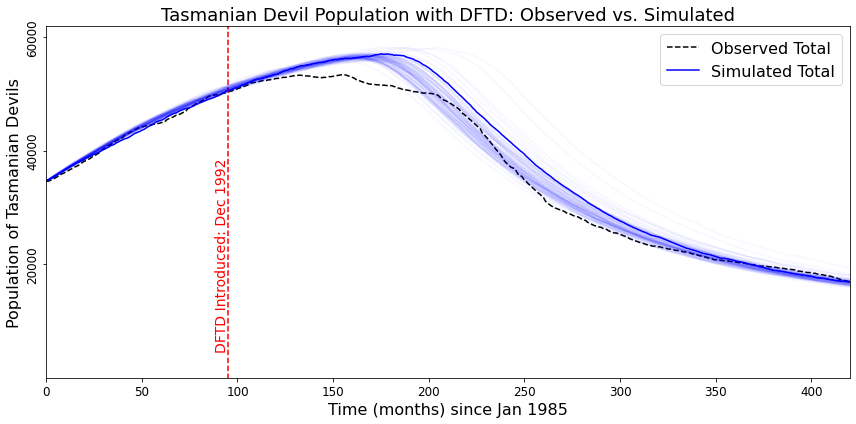

In [12]:
plt.figure(figsize=[12, 6])
plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=16)
plt.ylabel("Population of Tasmanian Devils", fontsize=16)
plt.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
plt.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
# plt.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.3, label='Juvenile')
# plt.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.3, label='Susceptible')
# plt.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.3, label='Exposed')
# plt.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.3, label='Infected')
# plt.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.3, label='Diseased')
plt.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--r')
plt.ylim([0, carry_cap])
plt.text(variables['DFTD_start']-7, 5000, "DFTD Introduced: "+dates[variables['DFTD_start']], rotation="vertical", color="red", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([20000,40000,60000],fontsize=12, rotation="vertical", va="center")
plt.xlim(0,eresults[0]['time'][-1])
plt.legend(loc='upper right', fontsize=16)
for n,r in enumerate(eresults):
    if n==0: continue
    plt.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
plt.tight_layout()
#plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")

<ipython-input-13-290d54e956a5>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


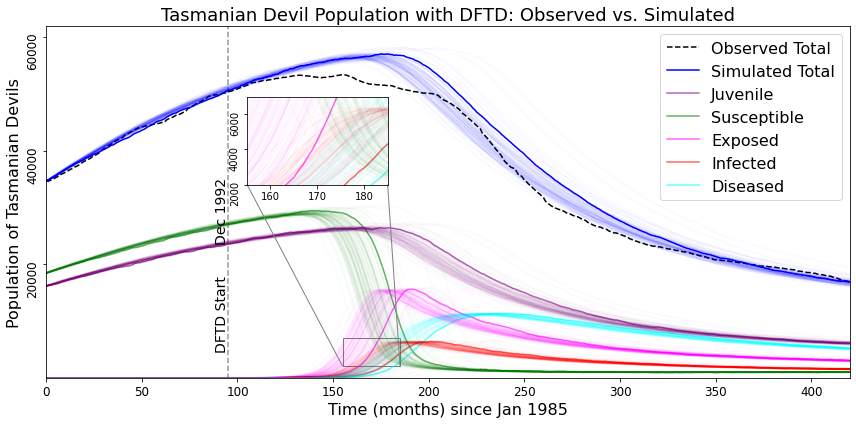

In [13]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
fig, ax1 = plt.subplots(figsize=[12, 6])

plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
ax1.text(variables['DFTD_start']-7, 24000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
#ax1.set_xlim([0, result[0]['time'][-1]])
#ax1.set_ylim([-3000, max(devil_pop)*1.25])
ax1.tick_params(axis='x', labelsize=12)
ax1.set_yticks([20000,40000,60000])
ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
ax1.legend(loc='upper right', fontsize=16)
ax1.set_ylim([0, carry_cap])
ax1.set_xlim(0,eresults[0]['time'][-1])
for n,r in enumerate(eresults):
    if n==0: continue
    ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
    ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
    ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
    ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
    ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
    ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.25,0.55,0.175,0.25])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

# plot in the inset
inst=155
ined=inst+31
#ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
#ax2.plot(eresults[0]['time'][inst:ined], eresults[0]['Devils'][inst:ined],'b', label="Simulation")
ax2.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
ax2.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
ax2.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
ax2.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
ax2.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
for n,r in enumerate(eresults):
    if n==0: continue
    #ax2.plot(eresults[n]['time'][inst:ined], eresults[n]['Devils'][inst:ined],'b', alpha=0.05)
    ax2.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
    ax2.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
    ax2.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
    ax2.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
    ax2.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
    ax2.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')
ax2.set_xlim(inst,ined-1)
ax2.set_ylim(2000,7000)
#ax2.set_yticks([49000,54000])
ax2.tick_params(axis='y', labelrotation=90)
    
plt.tight_layout()
#plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")

In [14]:
import numpy

In [15]:
ps_dftd_start_db={}

In [16]:
def sample_start_time(DFTD_start):
    global obs
    total_results = 100
    num_results = 0
    dists = numpy.zeros(total_results)
    while(num_results < total_results):
        ntraj = total_results-num_results
        print(f"\tRunning {ntraj}", end=' ')
        sys.stdout.flush()
        tic = time.time()
        eresults = event_model(DFTD_start=DFTD_start).run(number_of_trajectories=ntraj, solver=TauHybridCSolver)
        print(f"\tsimulation complete in {time.time()-tic}s")
        for r in eresults:
            if (r['Exposed'][-1] + r['Infected'][-1] + r['Diseased'][-1]) > 0:
                dists[num_results] = numpy.linalg.norm(r['Devils']-obs[0][0],2)
                num_results+=1
    d = numpy.average(dists)
    print(f"DFTD_start={DFTD_start} L2={d}")
    return d

In [17]:
ps_dftd_start_sweep=[40, 50, 60, 70, 75, 80,82,84,86,88,90,92,94,95,96,98, 100,101, 105,110,120]

In [18]:
for dftd_start in ps_dftd_start_sweep:
    if dftd_start in ps_dftd_start_db:
        print(f"dftd_start={dftd_start} already calculated L2={ps_dftd_start_db[dftd_start]}")
    else:
        print(f"Running dftd_start={dftd_start}")
        ps_dftd_start_db[dftd_start] = sample_start_time(dftd_start)

Running dftd_start=40
	Running 100 	simulation complete in 46.88654971122742s
DFTD_start=40 L2=149725.92964844173
Running dftd_start=50
	Running 100 	simulation complete in 55.0531530380249s
DFTD_start=50 L2=110207.5635610247
Running dftd_start=60
	Running 100 	simulation complete in 55.84318971633911s
	Running 1 	simulation complete in 12.524021863937378s
DFTD_start=60 L2=78908.23939708289
Running dftd_start=70
	Running 100 	simulation complete in 59.662312746047974s
DFTD_start=70 L2=51566.26250616014
Running dftd_start=75
	Running 100 	simulation complete in 45.953802824020386s
DFTD_start=75 L2=70940.11014971728
Running dftd_start=80
	Running 100 	simulation complete in 55.67413592338562s
DFTD_start=80 L2=41698.95949174238
Running dftd_start=82
	Running 100 	simulation complete in 64.22798705101013s
	Running 44 	simulation complete in 30.08085799217224s
DFTD_start=82 L2=54044.03944016575
Running dftd_start=84
	Running 100 	simulation complete in 51.160480976104736s
	Running 13 	simul

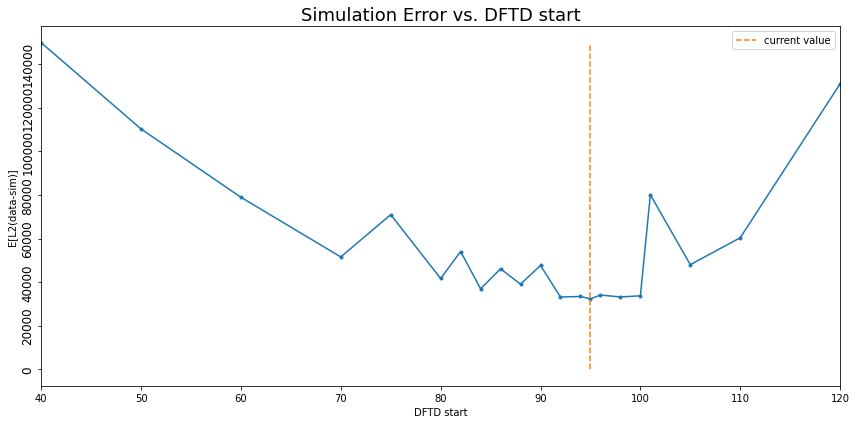

In [19]:
ps_dftd_start_dist=[]
for dftd_start in ps_dftd_start_sweep:
    ps_dftd_start_dist.append(ps_dftd_start_db[dftd_start])

plt.figure(figsize=[12, 6])
plt.title("Simulation Error vs. DFTD start", fontsize=18)
    
plt.plot(ps_dftd_start_sweep,ps_dftd_start_dist,'.-')
plt.xlabel('DFTD start')
plt.ylabel("E[L2(data-sim)]")
plt.yticks(fontsize=12, rotation="vertical", va="center")
plt.xlim(ps_dftd_start_sweep[0],ps_dftd_start_sweep[-1])
plt.tight_layout()
current_val = variables['DFTD_start']
plt.plot([current_val, current_val],[0,max(ps_dftd_start_dist)], '--',label="current value")
plt.legend()
plt.savefig("SimError-vs-DFTD_start.pdf")

In [20]:
maxval=math.inf
maxkey=''
for k,v in ps_dftd_start_db.items():
    if v<maxval:
        maxkey=k
        maxval=v
print(f"Selected value {maxkey}")

Selected value 95
